## Imports

In [1]:
import json
import pathlib
import warnings
warnings.filterwarnings("ignore", message="Lazy modules") # Ignore lazy module warnings

import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() # Apply seaborn theme to plots

from hyperopt import hp, tpe, rand

from src.cross_validation import kfold_train
from src.data import load_dataset, get_dataloader
from src.evaluation import find_best_run, evaluate_checkpoint, find_best_hyperparameters
from src.hyperopt import optimize_hyperparameters

## Configuration

In [2]:
train_dataset = load_dataset(filepath="data/train", resolution=(64, 64))
test_dataset = load_dataset(filepath="data/test", resolution=(64, 64))
test_dataloader = get_dataloader(test_dataset, batch_size=8)

space = {
    "kernel_size_conv": hp.choice("kernel_size_conv", [3, 5, 7]),
    "kernel_size_pool": hp.choice("kernel_size_pool", [2, 3]),
    "num_base_channels": hp.choice("num_base_channels", [4, 8, 16, 32]),
    "num_conv_blocks": hp.choice("num_conv_blocks", [2, 3]),
    "activation": hp.choice("activation", ["tanh", "relu", "leakyrelu"]),
    "optimizer": hp.choice("optimizer", ["sgd", "rmsprop", "adam"]),
    "learning_rate": hp.uniform("learning_rate", 0.0001, 0.01),
}

device = "cuda" if torch.cuda.is_available() else "cpu"

## Exercise 1

In [3]:
log_folder = pathlib.Path("runs_manual")
trial_id = "trial_before_hyperopt"

average_valid_loss = kfold_train(
    dataset=train_dataset,
    n_splits=5,
    batch_size=8,
    random_state=42,
    num_conv_blocks=2,
    num_base_channels=4,
    kernel_size_conv=3,
    kernel_size_pool=3,
    activation="relu",
    optimizer="adam",
    learning_rate=0.001,
    max_epochs=30,
    patience=3,
    device=device,
    log_folder=log_folder,
    trial_id=trial_id,
)

Trial ID: trial_before_hyperopt
  Fold 0 best valid loss: 0.47066953778266907
  Fold 1 best valid loss: 0.6929675191640854
  Fold 2 best valid loss: 0.4146951511502266
  Fold 3 best valid loss: 0.6825019419193268
  Fold 4 best valid loss: 0.6907805651426315
  Average best valid loss: 0.5903229430317879



### Plot learning curves

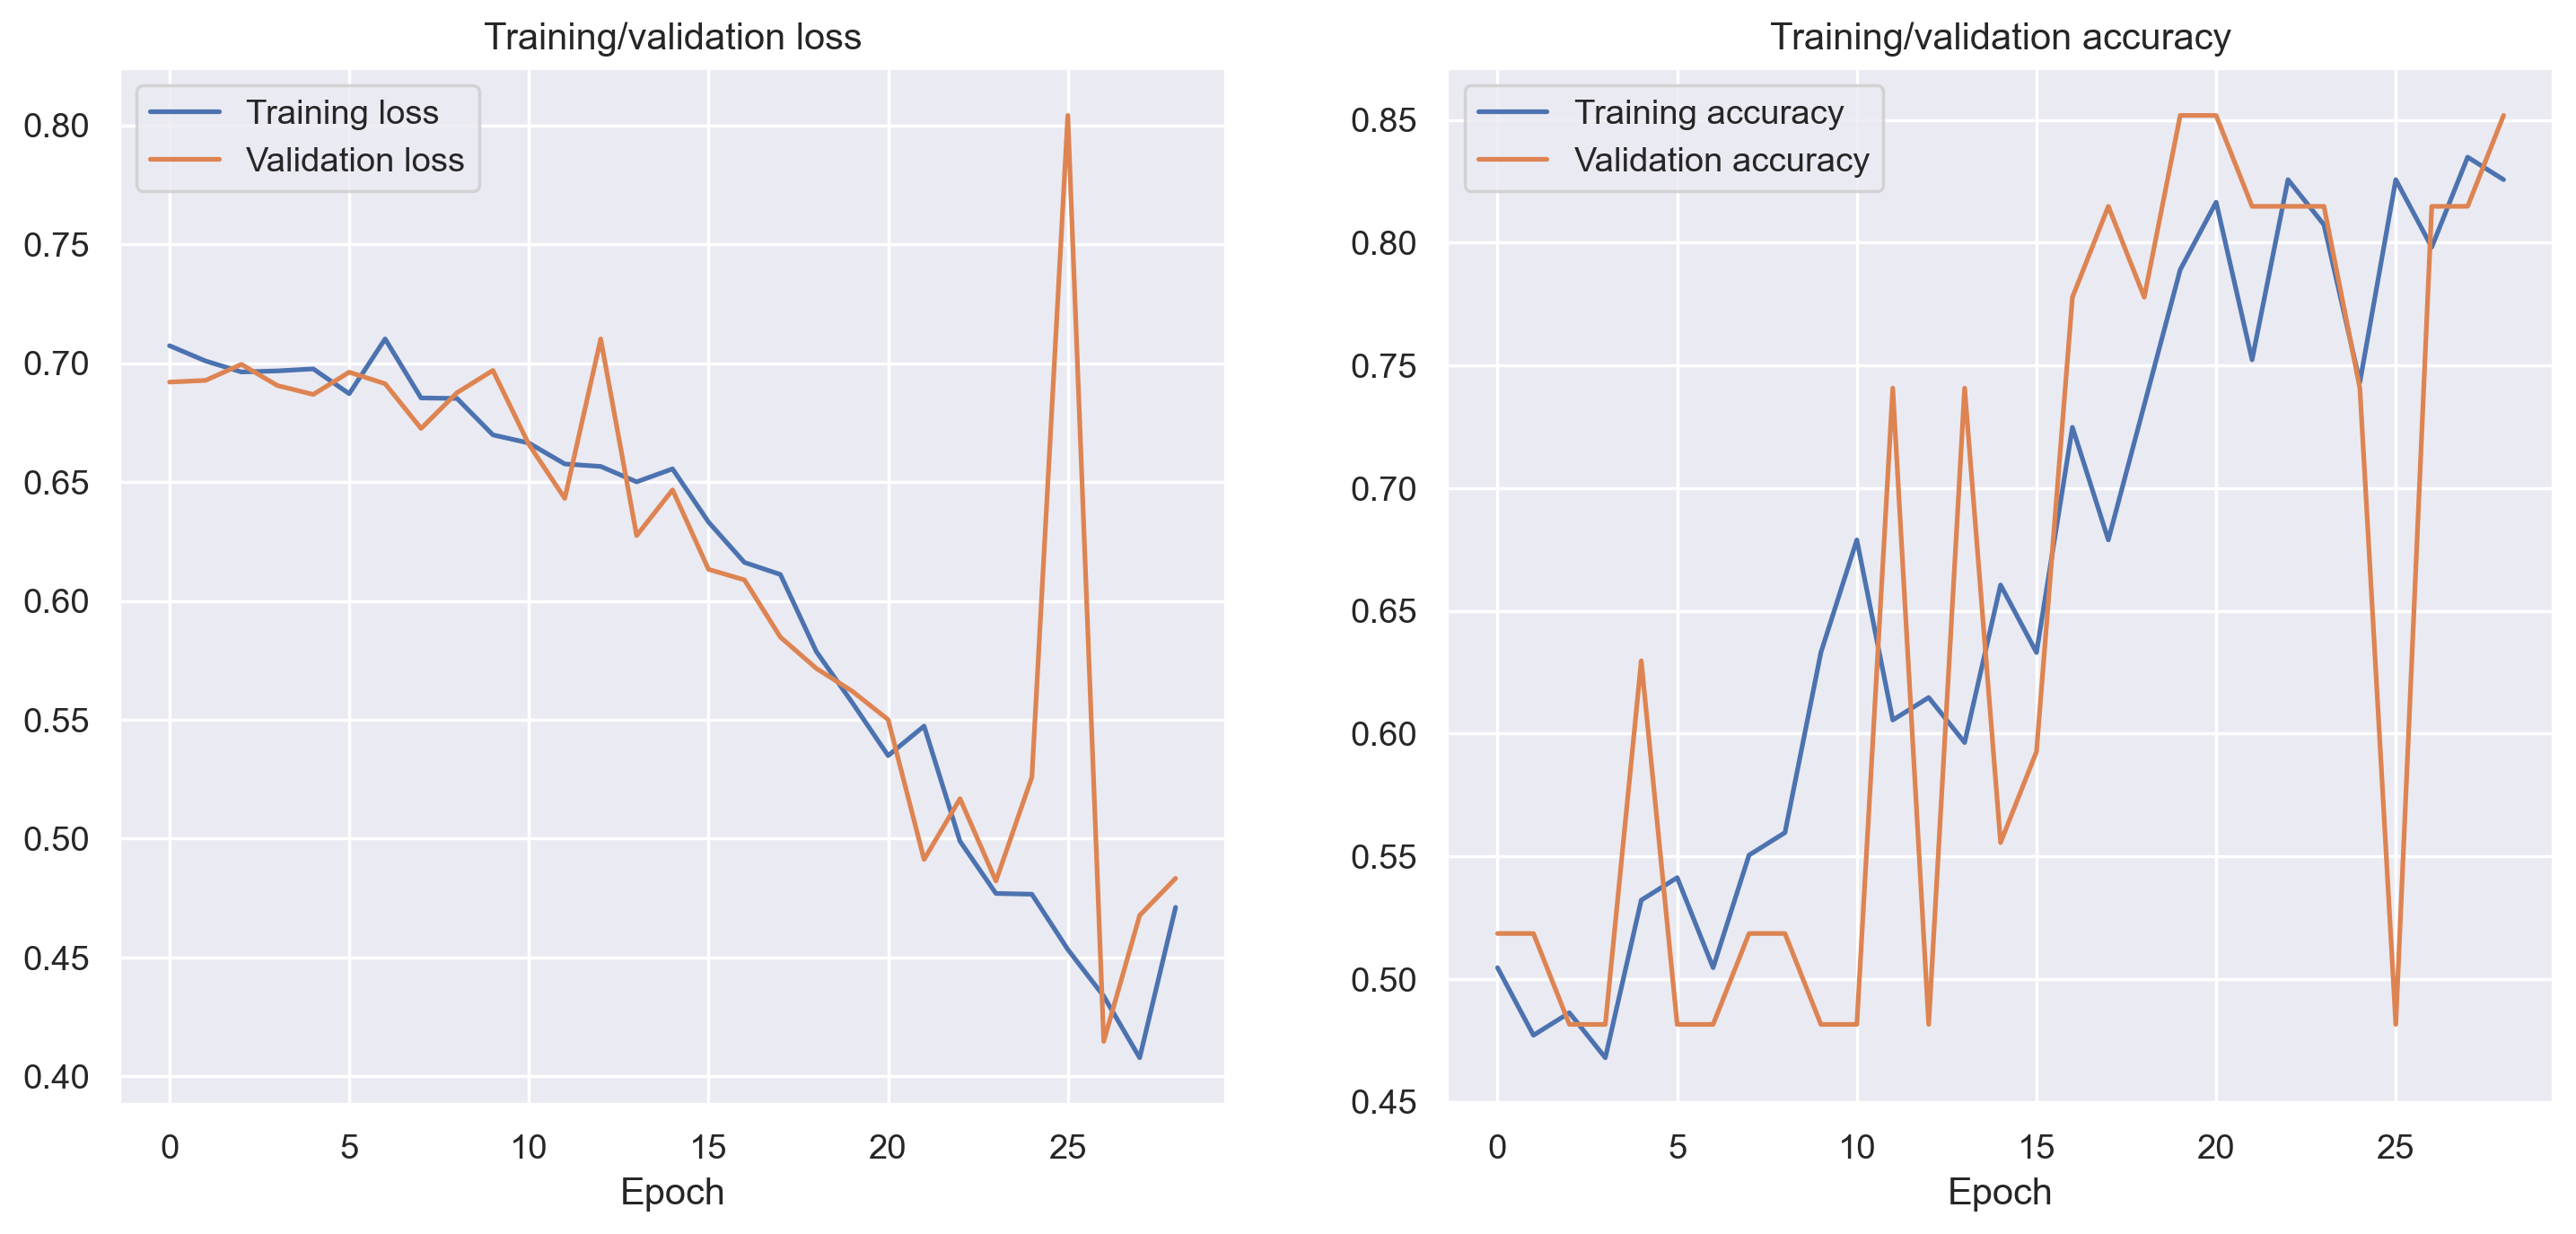

In [4]:
fig, (ax_left, ax_right) = plt.subplots(1, 2, dpi=250, figsize=(14, 6))
ax_left.set_xlabel("Epoch")
ax_right.set_xlabel("Epoch")
ax_left.set_title("Training/validation loss")
ax_right.set_title("Training/validation accuracy")

best_run_dir = find_best_run(log_folder / trial_id)

with open(best_run_dir / "logs.json", "r") as file:
    logs = json.load(file)

ax_left.plot(logs["train_loss"], label="Training loss")
ax_left.plot(logs["valid_loss"], label="Validation loss")
ax_right.plot(logs["train_accuracy"], label="Training accuracy")
ax_right.plot(logs["valid_accuracy"], label="Validation accuracy")

ax_left.legend()
ax_right.legend()

fig.savefig("plots/exercise-1-unoptimized.png", bbox_inches="tight")

### Run model on testing set

In [5]:
evaluate_checkpoint(run_dir=best_run_dir, test_dataloader=test_dataloader)

Test loss: 0.5478574931621552
Test accuracy: 0.6176470588235294


## Exercise 2

In [6]:
log_folder = pathlib.Path("runs_hyperopt_random")

optimize_hyperparameters(
    dataset=train_dataset,
    space=space,
    algo=rand.suggest,
    max_evals=50,
    n_splits=5,
    batch_size=8,
    random_state=42,
    max_epochs=30,
    patience=3,
    device=device,
    log_folder=log_folder,
)

print("Best hyperparameters:")
find_best_hyperparameters(log_folder)

Trial ID: trial_110b6b74357d31afea995a9d5d2e62de5cb60452
  Fold 0 best valid loss: 0.6914384663105011          
  Fold 1 best valid loss: 0.6921807825565338          
  Fold 2 best valid loss: 0.6895340532064438          
  Fold 3 best valid loss: 0.6920453161001205          
  Fold 4 best valid loss: 0.6916165798902512          
  Average best valid loss: 0.6913630396127701         
Trial ID: trial_110b6db50f914a53905e5b8de03db9e00877eaf7                           
  Fold 0 best valid loss: 0.6927583515644073                                       
  Fold 1 best valid loss: 0.6931129544973373                                       
  Fold 2 best valid loss: 0.6946558058261871                                       
  Fold 3 best valid loss: 0.693101242184639                                        
  Fold 4 best valid loss: 0.6912148296833038                                       
  Average best valid loss: 0.6929686367511749                                      
Trial ID: trial_110b6f6af

In [7]:
log_folder = pathlib.Path("runs_hyperopt_tpe")

optimize_hyperparameters(
    dataset=train_dataset,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    n_splits=5,
    batch_size=8,
    random_state=42,
    max_epochs=30,
    patience=3,
    device=device,
    log_folder=log_folder,
)

print("Best hyperparameters:")
find_best_hyperparameters(log_folder)

Trial ID: trial_110be71fb9791f2557dcbf93652fca926cee7688
  Fold 0 best valid loss: 0.5716480165719986          
  Fold 1 best valid loss: 0.38951949402689934         
  Fold 2 best valid loss: 0.46418362855911255         
  Fold 3 best valid loss: 0.4968934506177902          
  Fold 4 best valid loss: 0.2431478351354599          
  Average best valid loss: 0.4330784849822521         
Trial ID: trial_110beb1715a6bc30bad8ffee688cbbfe15a61a6d                             
  Fold 0 best valid loss: 0.6901668459177017                                         
  Fold 1 best valid loss: 0.6926805377006531                                         
  Fold 2 best valid loss: 0.6846327036619186                                         
  Fold 3 best valid loss: 0.6908605098724365                                         
  Fold 4 best valid loss: 0.6927233189344406                                         
  Average best valid loss: 0.6902127832174301                                        
Trial ID: t

## Exercise 3

In [14]:
log_folder = pathlib.Path("runs_manual")
trial_id = "trial_after_hyperopt"

average_valid_loss = kfold_train(
    dataset=train_dataset,
    n_splits=5,
    batch_size=8,
    random_state=42,
    num_conv_blocks=3,
    num_base_channels=32,
    kernel_size_conv=7,
    kernel_size_pool=2,
    activation="leakyrelu",
    optimizer="adam",
    learning_rate=0.001, # Rounded
    max_epochs=30,
    patience=3,
    device=device,
    log_folder=log_folder,
    trial_id=trial_id,
)

Trial ID: trial_after_hyperopt
  Fold 0 best valid loss: 0.31080374494194984
  Fold 1 best valid loss: 0.15975820738822222
  Fold 2 best valid loss: 0.5882527455687523
  Fold 3 best valid loss: 0.6928114891052246
  Fold 4 best valid loss: 0.28972021117806435
  Average best valid loss: 0.40826927963644266



### Plot learning curves

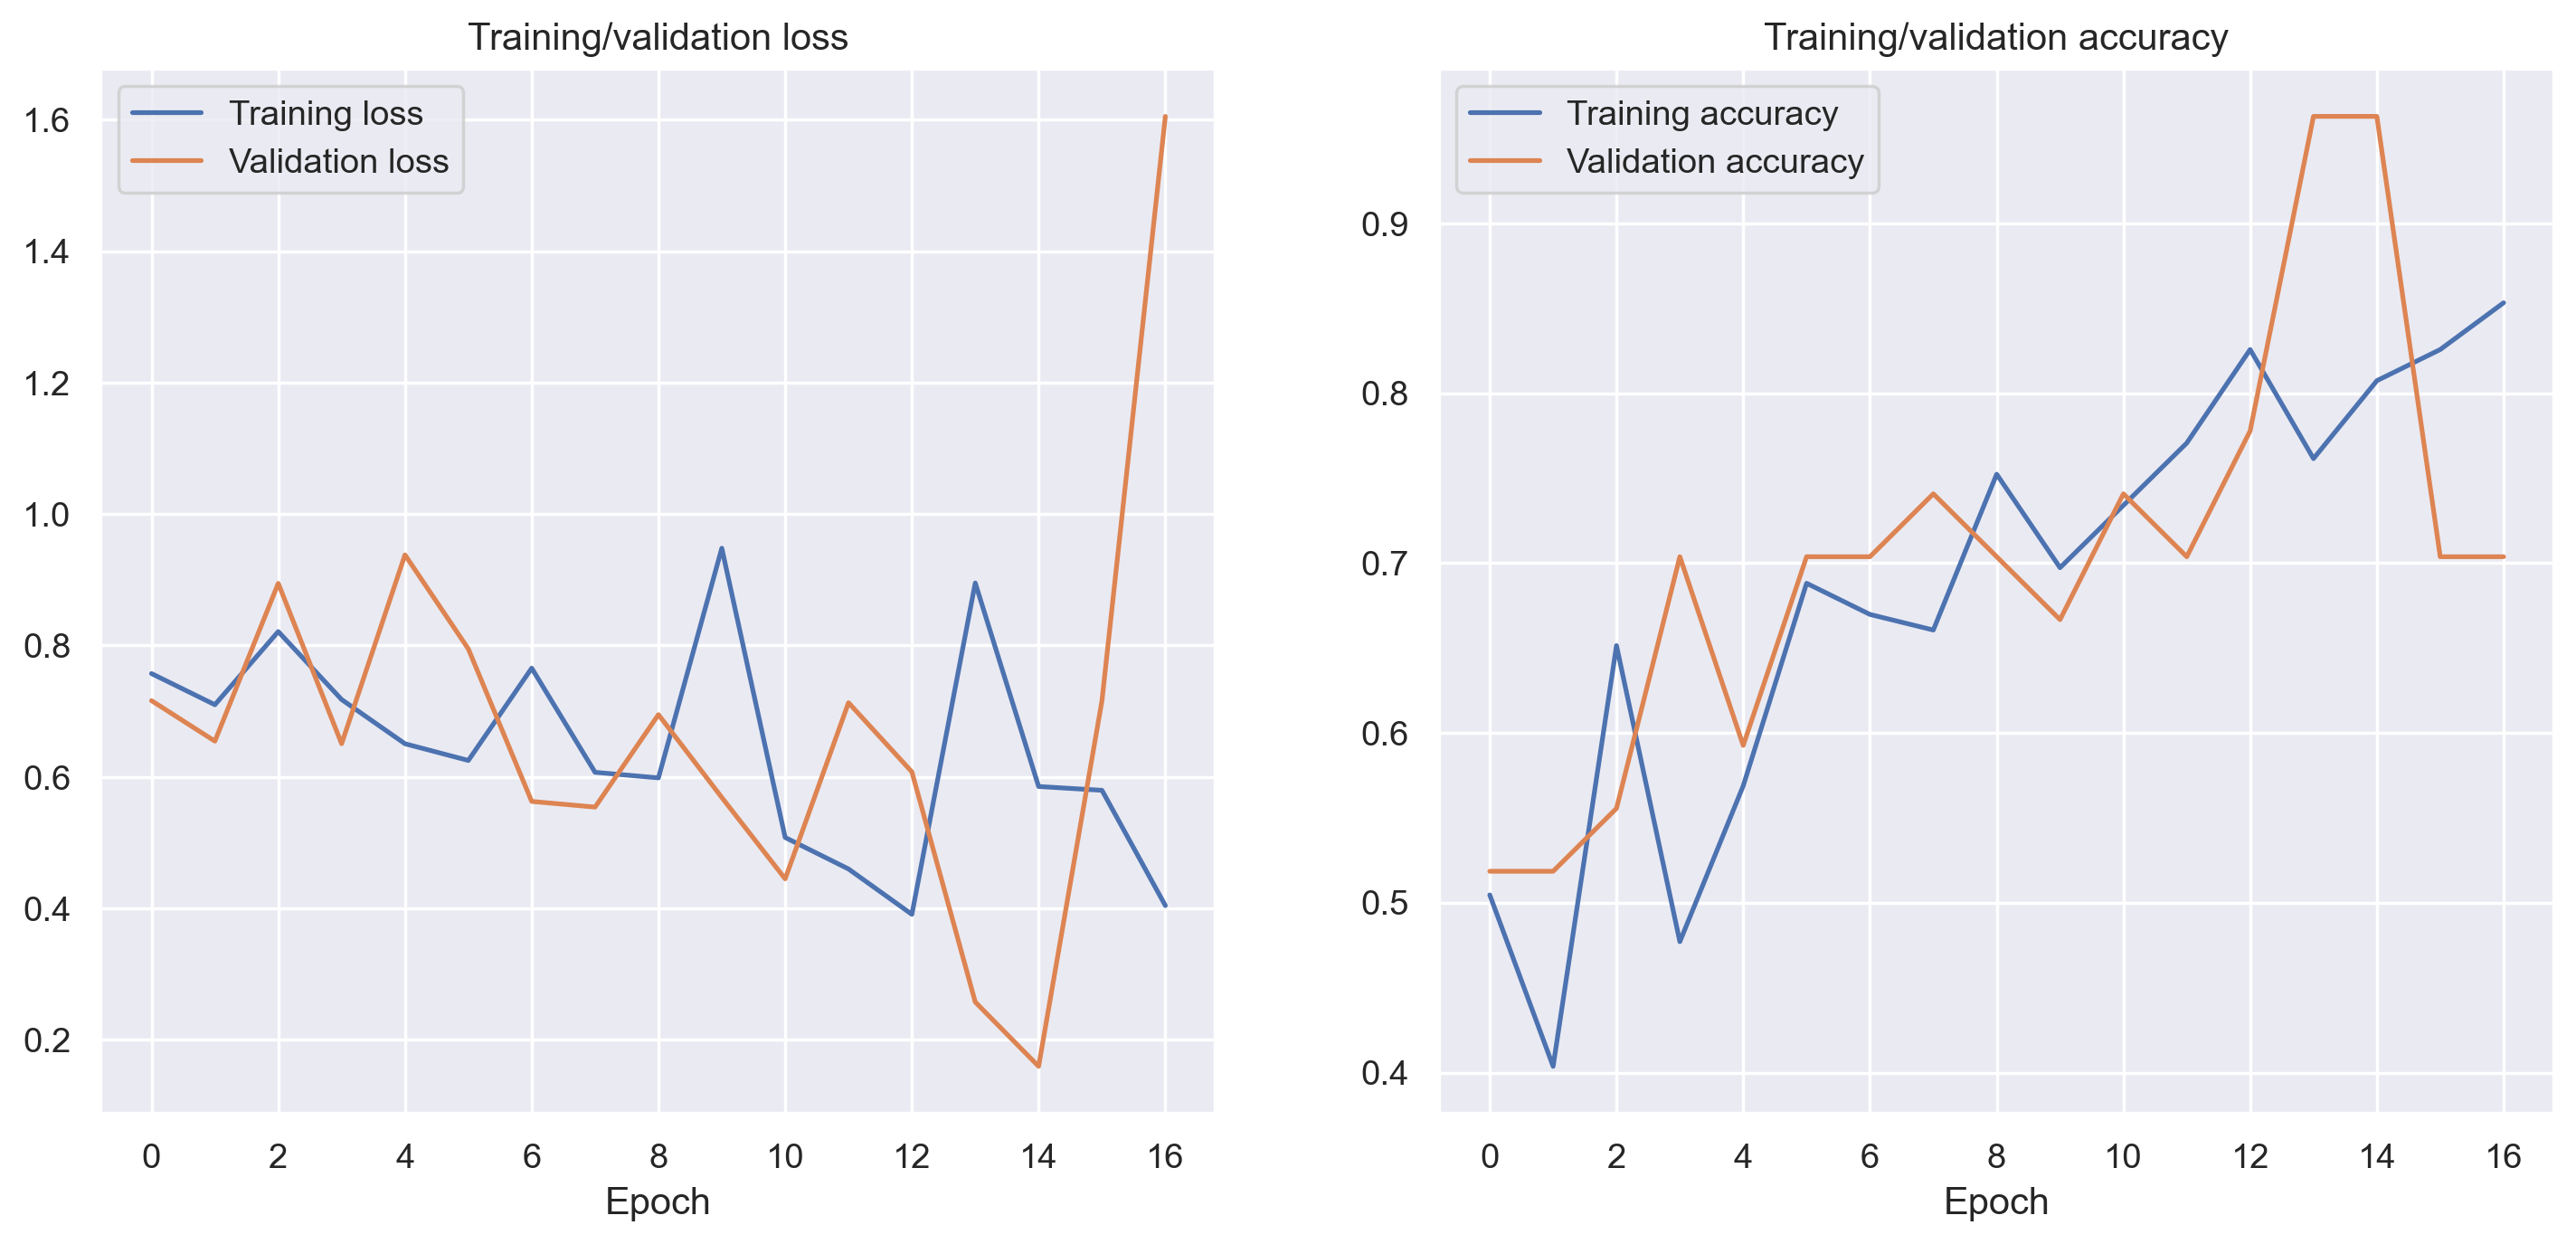

In [15]:
fig, (ax_left, ax_right) = plt.subplots(1, 2, dpi=250, figsize=(14, 6))
ax_left.set_xlabel("Epoch")
ax_right.set_xlabel("Epoch")
ax_left.set_title("Training/validation loss")
ax_right.set_title("Training/validation accuracy")

best_run_dir = find_best_run(log_folder / trial_id)

with open(best_run_dir / "logs.json", "r") as file:
    logs = json.load(file)

ax_left.plot(logs["train_loss"], label="Training loss")
ax_left.plot(logs["valid_loss"], label="Validation loss")
ax_right.plot(logs["train_accuracy"], label="Training accuracy")
ax_right.plot(logs["valid_accuracy"], label="Validation accuracy")

ax_left.legend()
ax_right.legend()

fig.savefig("plots/exercise-3-optimized.png", bbox_inches="tight")

### Run model on testing set

In [16]:
evaluate_checkpoint(run_dir=best_run_dir, test_dataloader=test_dataloader)

Test loss: 0.3096572183072567
Test accuracy: 0.8823529411764706
